In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import numpy as np
import xarray as xr
import zarr
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import random
import jax
import tensorflow as tf
from tqdm import tqdm
import jax.numpy as jnp
from jax import grad, jit, vmap
from utils.clim_loss_vit import custom_loss
#from utils.clim_loss import ClimateDownscalingLoss

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
jax.config.update('jax_enable_x64', True)
jax.random.PRNGKey(SEED)


# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

2025-03-10 09:40:25.497605: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741617625.512589 1727106 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741617625.516991 1727106 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Data Handling: Load and Resample Data
We will load the CMIP6 data and the GMFD observational data. We’ll resample the GMFD data to the CMIP6 resolution (e.g., ~100 km) to use as the target during training.



In [2]:
# Load the CMIP6 raw data (predictor variables)
cmip6_tas_path = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_tas = xr.open_zarr(cmip6_tas_path)

cmip6_pr_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_pr = xr.open_zarr(cmip6_pr_path)
cmip6_lat = cmip6_pr.lat
cmip6_lon = cmip6_pr.lon

cmip6_psl_path = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_psl = xr.open_zarr(cmip6_psl_path)

# Load the GMFD reference observational data (target variable)
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_tas_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_tas = xr.open_mfdataset(gmfd_tas_files, combine='by_coords')
gmfd_pr_files = [f'{gmfd_data_path}/prcp_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_pr = xr.open_mfdataset(gmfd_pr_files, combine='by_coords')
gmfd_pr['prcp'] = gmfd_pr['prcp'] * 86400

# Resample  CMIP6 to GMFD resolution (~25 km)
target_lat = gmfd_tas.lat
target_lon = gmfd_tas.lon
cmip6_high_tas = cmip6_tas['tas'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_pr['pr'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_high_pr = cmip6_high_pr.where(cmip6_high_pr > 0, 0)  # Set negative values to zero
cmip6_high_pr = cmip6_high_pr * 86400
cmip6_high_psl = cmip6_psl['psl'].interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

cmip6_high_tas['time'] = cmip6_high_tas['time'].dt.floor('D')
cmip6_high_pr['time'] = cmip6_high_pr['time'].dt.floor('D')

#### Load elevation

In [3]:
elev = xr.open_dataset('grids/elevation_0.25deg.nc')
elev_sub = elev.sel(latitude=slice(40.99986, 51.49986), longitude=slice( 6.69986, 30.99986 ))
elev_sub['elev'] = elev_sub['elev'].fillna(0) # convert NA to 0
elev_sub = elev_sub.rename({"latitude": "lat"})
elev_sub = elev_sub.rename({"longitude": "lon"})
# Rename the dimension and coordinate


elev_cmip6 = elev_sub.interp(lat=cmip6_lat, lon=cmip6_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
elev_cmip6['elev'] = elev_cmip6['elev'].clip(min=0)
cmip6_high_elev = elev_cmip6.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})

# Set cmip6_high_elev to 0 where cmip6_high_elev < 0 and elev_sub == 0
cmip6_high_elev = xr.where((cmip6_high_elev < 0) & (elev_sub['elev'] == 0), 0, cmip6_high_elev)
cmip6_high_elev['elev'] = cmip6_high_elev['elev'].clip(min=0)
#elev_dif = elev_sub - cmip6_high_elev
elev_dif = elev_sub 


# Check the new shape of 'elev'
elev_dif = elev_dif.squeeze(dim="z")

# elev_cmip6['elev'].plot(cmap = 'terrain')
# elev_dif_norm.plot(cmap = 'terrain')
# elev_dif['elev'].plot(cmap = 'terrain')


#### Transform (pr) and normalize

In [4]:
# Apply the log1p transformation to the 'prcp' variable
cmip6_high_pr_log1p = cmip6_high_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
cmip6_high_pr_log1p = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
   cmip6_high_pr,               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

# Apply the log1p transformation to the 'prcp' variable
gmfd_pr_log1p = gmfd_pr.copy()  # Make a copy to avoid modifying the original dataset
# Apply the log1p transformation to the precipitation data
gmfd_pr_log1p['prcp'] = xr.apply_ufunc(
    np.log1p,                 # The function to apply (log1p)
    gmfd_pr['prcp'],               # The data variable to transform
    dask="parallelized",      # Enable parallel computations with Dask
    output_dtypes=[float]     # Specify output data type
)

In [5]:
def normalize(data):
    min_val = data.min()
    max_val = data.max()
    return (data - min_val) / (max_val - min_val)

cmip6_tas_norm = normalize(cmip6_high_tas)
cmip6_psl_norm = normalize(cmip6_high_psl)
cmip6_pr_norm = normalize(cmip6_high_pr_log1p)
gmfd_tas_norm = normalize(gmfd_tas['tas'])
gmfd_pr_norm = normalize(gmfd_pr_log1p['prcp'])
elev_dif_norm = normalize(elev_dif['elev'])


# Convert data to NumPy arrays for use in Keras
cmip6_train_tas = cmip6_tas_norm.values
cmip6_train_psl = cmip6_psl_norm.values
cmip6_train_pr = cmip6_pr_norm.values
gmfd_train_pr = gmfd_pr_norm.values
gmfd_train_tas = gmfd_tas_norm.values
elev_dif_norm = elev_dif_norm.values

In [6]:
print(elev_dif_norm.shape)
print(gmfd_train_tas.shape)
elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], 23741, axis=0)
print(elev_dif_norm_final.shape)

(1, 42, 97)
(23741, 42, 97)
(23741, 42, 97)


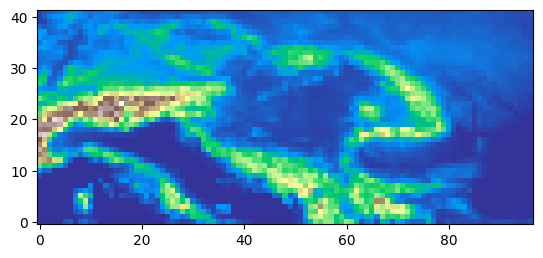

In [7]:
plt.imshow(elev_dif_norm_final[10000, :,:], origin='lower', cmap='terrain')

#### Compute residuals

In [8]:
import xarray as xr

res_tas = gmfd_train_tas  - cmip6_train_tas
res_pr = gmfd_train_pr  - cmip6_train_pr

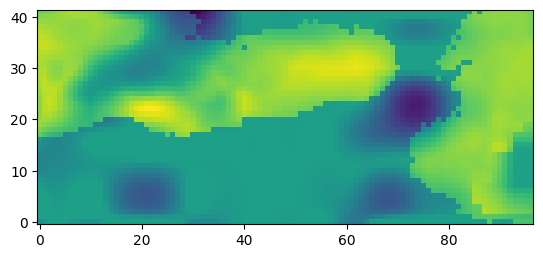

In [9]:
plt.imshow(res_pr[100, :,:], origin='lower', cmap='viridis')

#### Split the data
Train set: The first portion of the time period (e.g., 60% of the time series).
Validation set: The next portion of the time series (e.g., the following 20% of the time series).
Test set: The final portion of the time series (e.g., the last 20%): 

In [10]:
import pandas as pd
index_2004 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2004-12-31'))[0][0])
index_2009 = int(np.where(cmip6_tas_norm.time.values == pd.to_datetime('2009-12-31'))[0][0])

In [11]:
# Reshape data to add the channel dimension
cmip6_train_tas_reshaped = cmip6_train_tas[..., np.newaxis]
cmip6_train_pr_reshaped = cmip6_train_psl[..., np.newaxis]
cmip6_train_slp_reshaped = cmip6_train_psl[..., np.newaxis]
elev_dif_norm_reshaped = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_train_combined = np.concatenate((cmip6_train_tas_reshaped,cmip6_train_pr_reshaped, cmip6_train_slp_reshaped, elev_dif_norm_reshaped), axis=-1)

gmfd_train_tas_reshaped = gmfd_train_tas[..., np.newaxis]
gmfd_train_pr_reshaped = gmfd_train_pr[..., np.newaxis]

gmfd_train_combined = np.concatenate((gmfd_train_tas_reshaped,gmfd_train_pr_reshaped), axis=-1)

res_tas_reshaped = res_tas[..., np.newaxis]
res_pr_reshaped = res_pr[..., np.newaxis]

res_train_combined = np.concatenate((res_tas_reshaped, res_pr_reshaped), axis=-1)

In [12]:
# Split the data while preserving the temporal structure
X_train = cmip6_train_combined[:index_2004]
y_train = gmfd_train_combined[:index_2004]
res_train = res_train_combined[:index_2004]

X_val = cmip6_train_combined[index_2004:index_2009]
y_val = gmfd_train_combined[index_2004:index_2009]
res_val = res_train_combined[index_2004:index_2009]

X_test = cmip6_train_combined[index_2009:]
y_test = gmfd_train_combined[index_2009:]
res_test = res_train_combined[index_2009:]


# # Reshape X data to include the temporal dimension
# X_train = np.expand_dims(X_train, axis=1)
# X_val = np.expand_dims(X_val, axis=1)
# X_test = np.expand_dims(X_test, axis=1)

# # Reshape y data to include the temporal dimension
# y_train = np.expand_dims(y_train, axis=1)
# y_val = np.expand_dims(y_val, axis=1)
# y_test = np.expand_dims(y_test, axis=1)

# # Reshape y data to include the temporal dimension
# res_train = np.expand_dims(res_train, axis=1)
# res_val = np.expand_dims(res_val, axis=1)
# res_test = np.expand_dims(res_test, axis=1)


In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(res_train.shape)
print(res_val.shape)
print(res_test.shape)

(20088, 42, 97, 4)
(1826, 42, 97, 4)
(1827, 42, 97, 4)
(20088, 42, 97, 2)
(1826, 42, 97, 2)
(1827, 42, 97, 2)


#### Create temporal sequences

In [14]:
def create_temporal_sequences_centered(data, window_size):
    total_seq_length = 2 * window_size + 1
    sequences = []
    
    # For all time points
    for i in range(len(data)):
        sequence = np.zeros((total_seq_length,) + data.shape[1:])
        
        # Handle past values
        for j in range(window_size):
            if i - j >= 0:  # If we have data for this past point
                sequence[window_size - j] = data[i - j]
            else:  # If we don't have data, use the earliest available
                sequence[window_size - j] = data[0]
        
        # Current value
        sequence[window_size] = data[i]
        
        # Handle future values
        for j in range(window_size):
            if i + j + 1 < len(data):  # If we have data for this future point
                sequence[window_size + j + 1] = data[i + j + 1]
            else:  # If we don't have data, use the last available
                sequence[window_size + j + 1] = data[-1]
        
        sequences.append(sequence)
    
    return np.array(sequences)

window_size = 3

In [15]:
X_train_seq = create_temporal_sequences_centered(X_train, window_size)  
X_val_seq = create_temporal_sequences_centered(X_val, window_size)      
X_test_seq = create_temporal_sequences_centered(X_test, window_size)     
y_train_seq = create_temporal_sequences_centered(y_train, window_size) 
y_val_seq = create_temporal_sequences_centered(y_val, window_size)     
y_test_seq = create_temporal_sequences_centered(y_test, window_size)   

res_train_seq = create_temporal_sequences_centered(res_train, window_size) 
res_val_seq = create_temporal_sequences_centered(res_val, window_size)     
res_test_seq = create_temporal_sequences_centered(res_test, window_size) 

print("X_train shape:", X_train_seq.shape)
print("X_val shape:", X_val_seq.shape)
print("y_train shape:", y_train_seq.shape)
print("y_val shape:", y_val_seq.shape)
print("res_train shape:", res_train_seq.shape)
print("res_val shape:", res_val_seq.shape)


X_train shape: (20088, 7, 42, 97, 4)
X_val shape: (1826, 7, 42, 97, 4)
y_train shape: (20088, 7, 42, 97, 2)
y_val shape: (1826, 7, 42, 97, 2)
res_train shape: (20088, 7, 42, 97, 2)
res_val shape: (1826, 7, 42, 97, 2)


#### Build the VIT-transformenrs (Keras with JAX Backend)


In [16]:
from keras import ops
from keras.layers import (
    Input, Dense, Dropout, MultiHeadAttention, LayerNormalization,
    Add, Conv3D, Reshape, TimeDistributed, Layer
)
from keras.models import Model, Sequential  
from keras import regularizers
from keras.saving import register_keras_serializable

# **Fourier Positional Encoding Layer** (No changes)
@register_keras_serializable()
class FourierPositionalEncoding(Layer):
    def __init__(self, embed_dim, max_freq=10, **kwargs):
        """
        Fourier positional encoding for spatial and temporal positions.
        Args:
            embed_dim: The dimension of the embeddings.
            max_freq: The maximum frequency for encoding.
        """
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.max_freq = max_freq

    def call(self, inputs):
        """
        Compute Fourier positional encodings and add them to the inputs.
        Args:
            inputs: Input tensor of shape (batch_size, seq_len, embed_dim).
        Returns:
            Tensor with Fourier positional encodings added.
        """
        batch_size, seq_len, embed_dim = ops.shape(inputs)

        # Generate positional values (normalized between 0 and 1)
        positions = ops.linspace(0.0, 1.0, seq_len)

        # Generate frequency bands
        freq_bands = ops.power(2.0, ops.linspace(0.0, self.max_freq, self.embed_dim // 2))

        # Compute Fourier features
        encodings = ops.matmul(ops.expand_dims(positions, axis=-1), ops.expand_dims(freq_bands, axis=0))  # seq_len x (embed_dim // 2)
        sin_encodings = ops.sin(encodings)
        cos_encodings = ops.cos(encodings)

        # Concatenate sine and cosine encodings
        positional_encodings = ops.concatenate([sin_encodings, cos_encodings], axis=-1)  # seq_len x embed_dim
        positional_encodings = ops.expand_dims(positional_encodings, axis=0)  # Add batch dimension
        positional_encodings = ops.broadcast_to(positional_encodings, [batch_size, seq_len, embed_dim])

        # Add positional encodings to inputs
        return inputs + positional_encodings

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "max_freq": self.max_freq
        })
        return config

# **Residual Multi-Scale Patch Embedding Layer** (Modified num_scales handling)
@register_keras_serializable()
class ResidualMultiScalePatchEmbedding(Layer):
    def __init__(self, patch_size, embed_dim, num_scales=3, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_scales = num_scales

    def build(self, input_shape):
        self.convs = [
            Conv3D(
                filters=self.embed_dim // self.num_scales,
                kernel_size=(k, k, k),
                strides=self.patch_size,
                padding='same',
                name=f"scale_{k}x{k}x{k}"
            )
            for k in range(3, 3 + self.num_scales)  # Dynamic kernel sizes
        ]
        self.fusion = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=1,
            padding="same",
            name="multi_scale_fusion"
        )
        self.residual_proj = Conv3D(
            filters=self.embed_dim,
            kernel_size=1,
            strides=self.patch_size,
            padding="same",
            name="residual_projection"
        )

    def call(self, x):
        batch_size = ops.shape(x)[0]
        multi_scale_features = [conv(x) for conv in self.convs]
        combined_features = ops.concatenate(multi_scale_features, axis=-1)
        fused_features = self.fusion(combined_features)
        residual = self.residual_proj(x)
        fused_features += residual
        _, t, h, w, c = ops.shape(fused_features)
        return ops.reshape(fused_features, (batch_size, t * h * w, c))

    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim,
            "num_scales": self.num_scales
        })
        return config

# **Spatial-Temporal Attention Block** (Simplified with unified attention)
@register_keras_serializable()
class SpatialTemporalAttentionBlock(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout, weight_decay, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        self.weight_decay = weight_decay

    def build(self, input_shape):
        # Unified Spatial-Temporal Attention
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout
        )
        # Layer normalizations
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        # Feed-forward network (MLP)
        self.mlp = Sequential([
            Dense(self.mlp_dim, activation="gelu", kernel_regularizer=regularizers.L2(self.weight_decay)),
            Dropout(self.dropout),
            Dense(self.embed_dim, kernel_regularizer=regularizers.L2(self.weight_decay)),
            Dropout(self.dropout)
        ])

    def call(self, inputs):
        attn_output = self.attention(inputs, inputs)  # Unified attention
        x = Add()([inputs, attn_output])
        x = self.layernorm1(x)

        # Feed-forward network (MLP)
        mlp_output = self.mlp(x)
        return self.layernorm2(Add()([x, mlp_output]))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout,
            "weight_decay": self.weight_decay
        })
        return config

# **ViT Transformer** (Modified with dynamic output units and other improvements)
def vit_transformer(input_shape, patch_size, embed_dim, num_heads, transformer_layers, mlp_dim, dropout, weight_decay):
    inputs = Input(shape=input_shape)
    x = ResidualMultiScalePatchEmbedding(patch_size=patch_size, embed_dim=embed_dim, num_scales=3)(inputs)
    x = FourierPositionalEncoding(embed_dim=embed_dim, max_freq=10)(x)

    for _ in range(transformer_layers):
        x = SpatialTemporalAttentionBlock(
            embed_dim=embed_dim, num_heads=num_heads, mlp_dim=mlp_dim, dropout=dropout, weight_decay=weight_decay
        )(x)

    num_time_steps = input_shape[0]
    _, num_patches, embed_dim = ops.shape(x)
    num_spatial_patches = num_patches // num_time_steps
    x = Reshape((num_time_steps, num_spatial_patches * embed_dim))(x)

    x = TimeDistributed(Dense(units=mlp_dim // 2, activation="gelu", kernel_regularizer=regularizers.L2(weight_decay)))(x)
    x = TimeDistributed(Dropout(dropout))(x)
    total_units_per_timestep = input_shape[1] * input_shape[2] * 2 
    x = TimeDistributed(Dense(units=total_units_per_timestep, activation="linear", kernel_regularizer=regularizers.L2(weight_decay)))(x)
    x = TimeDistributed(Reshape(target_shape=(input_shape[1], input_shape[2], 2)))(x) 

    return Model(inputs, x)

# **Example Usage** (Adjusted input shape and num_scales)
input_shape = (7, 42, 97, 4) # Updated input shape 
patch_size = (1, 7, 7)

model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=320,
    num_heads=8,
    transformer_layers=6,
    mlp_dim=512,
    dropout=0.2,
    weight_decay=0.001
)

model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 42, 97, 4)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_multi_scale_patch_emb… │ (None, 588, 320)       │       195,582 │
│ (ResidualMultiScalePatchEmbedd… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fourier_positional_encoding     │ (None, 588, 320)       │             0 │
│ (FourierPositionalEncoding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast (Cast)                     │ (None, 588, 320)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_temporal_attention_blo… │ (None, 588, 320)       │       740,672 │
│ (SpatialTemporalAttentionBlock) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 26880)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 7, 256)         │     6,881,536 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 7, 256)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 7, 8148)        │     2,094,036 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 7, 42, 97, 2)   │             0 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,615,186 (51.94 MB)

 Trainable params: 13,615,186 (51.94 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [17]:
import keras
from keras import ops
from keras.losses import Loss
from keras.saving import register_keras_serializable

@register_keras_serializable()
class ClimateDownscalingLoss(Loss):
    def __init__(self, 
                 spatial_weight_temp=1.0, gradient_weight_temp=0.5, temporal_weight_temp=0.3,
                 spatial_weight_precip=1.0, gradient_weight_precip=0.4, temporal_weight_precip=0.1,
                 mse_weight_temp=1.0, mse_weight_precip=0.5,  
                 observation_weight=1.0,
                 **kwargs):
        super().__init__(**kwargs)
        
        # Weights for temperature
        self.spatial_weight_temp = spatial_weight_temp
        self.gradient_weight_temp = gradient_weight_temp
        self.temporal_weight_temp = temporal_weight_temp
        self.mse_weight_temp = mse_weight_temp
        
        # Weights for precipitation
        self.spatial_weight_precip = spatial_weight_precip
        self.gradient_weight_precip = gradient_weight_precip
        self.temporal_weight_precip = temporal_weight_precip
        self.mse_weight_precip = mse_weight_precip

        self.observation_weight = observation_weight

        self.epsilon = 1e-6

    def call(self, y_true, y_pred, y_low_res=None):
        # Split channels (temperature and precipitation)
        y_true_temp = y_true[:, :, :, :, 0:1]
        y_pred_temp = y_pred[:, :, :, :, 0:1]
        y_true_precip = y_true[:, :, :, :, 1:2]
        y_pred_precip = y_pred[:, :, :, :, 1:2]

        # --- Observation Loss  ---
        observation_loss = (
            self.mse_weight_temp * ops.mean(ops.square(y_true_temp - y_pred_temp)) +
            self.mse_weight_precip * ops.mean(ops.square(y_true_precip - y_pred_precip))
        )

        # --- Regularization Loss (spatial, temporal, physical constraints) ---

        # Spatial Gradient Loss 
        def spatial_gradients(x):
            dy = x[:, :, 1:, :, :] - x[:, :, :-1, :, :]
            dx = x[:, :, :, 1:, :] - x[:, :, :, :-1, :]
            return dy, dx

        # Spatial gradients for temperature
        _, true_dx_temp = spatial_gradients(y_true_temp)
        _, pred_dx_temp = spatial_gradients(y_pred_temp)

        spatial_gradient_loss_temp = ops.mean(ops.square(true_dx_temp - pred_dx_temp)) + self.epsilon

        # Spatial gradients for precipitation
        _, true_dx_precip = spatial_gradients(y_true_precip)
        _, pred_dx_precip = spatial_gradients(y_pred_precip)

        spatial_gradient_loss_precip = ops.mean(ops.square(true_dx_precip - pred_dx_precip)) + self.epsilon

        # Temporal Gradient Loss
        def temporal_gradients(x):
            dt = x[:, 1:, :, :, :] - x[:, :-1, :, :, :]
            return dt

        # Temporal gradients for temperature
        true_dt_temp = temporal_gradients(y_true_temp)
        pred_dt_temp = temporal_gradients(y_pred_temp)

        temporal_gradient_loss_temp = ops.mean(ops.square(true_dt_temp - pred_dt_temp)) + self.epsilon

        # Temporal gradients for precipitation
        true_dt_precip = temporal_gradients(y_true_precip)
        pred_dt_precip = temporal_gradients(y_pred_precip)

        temporal_gradient_loss_precip = ops.mean(ops.square(true_dt_precip - pred_dt_precip)) + self.epsilon

        regularization_loss = (
            self.spatial_weight_temp * spatial_gradient_loss_temp
            + self.temporal_weight_temp * temporal_gradient_loss_temp
            + self.spatial_weight_precip * spatial_gradient_loss_precip
            + self.temporal_weight_precip * temporal_gradient_loss_precip
            # + other regularization terms... (add other constraints here)
        )

        # --- Total Loss ---
        total_loss = (
            self.observation_weight * observation_loss +
            regularization_loss
        )

        return total_loss

    def get_config(self):
        config = super().get_config()
        config.update({
            "spatial_weight_temp": self.spatial_weight_temp,
            "gradient_weight_temp": self.gradient_weight_temp,
            "temporal_weight_temp": self.temporal_weight_temp,
            "mse_weight_temp": self.mse_weight_temp,
            "spatial_weight_precip": self.spatial_weight_precip,
            "gradient_weight_precip": self.gradient_weight_precip,
            "temporal_weight_precip": self.temporal_weight_precip,
            "mse_weight_precip": self.mse_weight_precip,
            "observation_weight": self.observation_weight
        })
        return config

In [18]:
print(X_train_seq.shape)

(20088, 7, 42, 97, 4)


In [19]:

from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN

# Model setup
input_shape = (7, 42, 97, 4)
patch_size = (1, 7, 7)


model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=300,
    num_heads=10,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.2,
    weight_decay=0.01
)


climate_loss = ClimateDownscalingLoss(
    spatial_weight_temp=0.1,
    gradient_weight_temp=0.05,
    temporal_weight_temp=0.05,
    spatial_weight_precip=0.5,
    gradient_weight_precip=0.05,
    temporal_weight_precip=0.05,
    mse_weight_temp=1.0,
    mse_weight_precip=1.0,
    observation_weight=0.01

)

# Learning rate schedule
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=50,
    t_mul=2.0,
    m_mul=0.8,
    alpha=1e-6
)

# Optimizer
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)


# Compile model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Callbacks
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f'\nLearning rate for epoch {epoch+1} is {lr}')

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    ModelCheckpoint(
        filepath='models/vit_transformer_best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    TerminateOnNaN(),
    LRLogger()
]

# Training
history = model.fit(
    X_train_seq, res_train_seq,
    validation_data=(X_val_seq, res_val_seq),
    epochs=500,
    batch_size=100,
    callbacks=callbacks,
    verbose=1,
    shuffle=False
)

# Print results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - loss: 61.5717 - mean_absolute_error: 0.1103 - root_mean_squared_error: 0.1752
Epoch 1: val_loss improved from inf to 45.03180, saving model to models/vit_transformer_best_model.keras

Learning rate for epoch 1 is 5.426925522174459e-05
201/201 ━━━━━━━━━━━━━━━━━━━━ 143s 608ms/step - loss: 61.5419 - mean_absolute_error: 0.1103 - root_mean_squared_error: 0.1752 - val_loss: 45.0318 - val_mean_absolute_error: 0.1040 - val_root_mean_squared_error: 0.1703
Epoch 2/500
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - loss: 41.8818 - mean_absolute_error: 0.1032 - root_mean_squared_error: 0.1684
Epoch 2: val_loss improved from 45.03180 to 35.30696, saving model to models/vit_transformer_best_model.keras

Learning rate for epoch 2 is 4.9094569322991516e-05
201/201 ━━━━━━━━━━━━━━━━━━━━ 97s 404ms/step - loss: 41.8720 - mean_absolute_error: 0.1033 - root_mean_squared_error: 0.1684 - val_loss: 35.3070 - val_mean_absolute_error: 0.1033 - val_root_mean

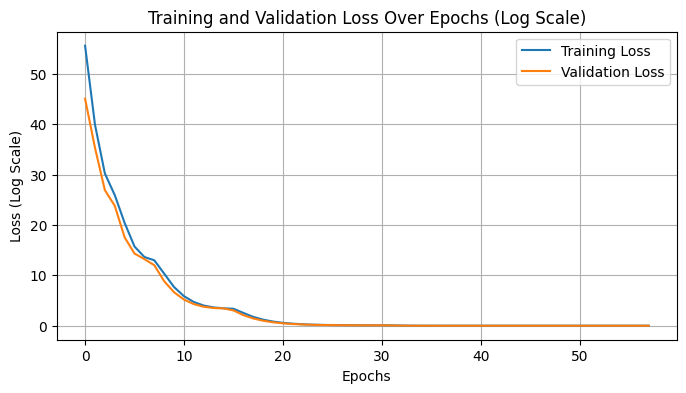

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.figure(figsize=(8, 4))

# Plotting the training and validation loss with log scale on y-axis
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# Title and labels
plt.title('Training and Validation Loss Over Epochs (Log Scale)')
plt.xlabel('Epochs')
plt.ylabel('Loss (Log Scale)')

# Set y-axis to log scale
#plt.yscale('log')

# Optional: Set y-axis limits (adjust these as needed for your data)
#plt.ylim(0,1)  # Example: Set limits from 0.001 to 10

# Show legend
plt.legend()

# Add grid for clarity
plt.grid(which='both')  # Add grid for both major and minor ticks

# Show the plot
plt.show()

#### Evaluate the model on validation data

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Load the model

from keras.models import load_model

model_saved = load_model('models/vit_transformer_best_model.keras')

In [22]:
# Get the mean and std from the training set for denormalization
cmip6_high_tas_min = cmip6_high_tas.min().values
cmip6_high_tas_max = cmip6_high_tas.max().values
cmip6_high_pr_min = cmip6_high_pr_log1p.min().values
cmip6_high_pr_max = cmip6_high_pr_log1p.max().values

# Get the mean and std from the training set for denormalization
gmfd_min_tas = gmfd_tas['tas'].min().values
gmfd_max_tas = gmfd_tas['tas'].max().values
gmfd_min_pr = gmfd_pr_log1p['prcp'].min().values
gmfd_max_pr = gmfd_pr_log1p['prcp'].max().values


# Generate predictions on validation data
y_pred = model_saved.predict(X_test_seq)


58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 131ms/step


In [23]:

# put back the residuals
y_pred_tas = X_test_seq[:,window_size,:,:,0] +  y_pred[:,window_size,:,:,0]
y_pred_pr = X_test_seq[:,window_size,:,:,1] +  y_pred[:,window_size,:,:,1]

print(y_pred.shape)
print(y_test_seq[:,window_size,:,:,0].shape)
# Back-transform the predictions for evaluation
y_test_denorm_tas = y_test_seq[:,window_size,:,:,0] * (gmfd_max_tas - gmfd_min_tas) + gmfd_min_tas
y_pred_denorm_tas = y_pred_tas * (cmip6_high_tas_max - cmip6_high_tas_min) + cmip6_high_tas_min

y_test_denorm_pr = y_test_seq[:,window_size,:,:,1] * (gmfd_max_pr - gmfd_min_pr) + gmfd_min_pr
y_pred_denorm_pr = y_pred_pr * (cmip6_high_pr_max - cmip6_high_pr_min) + cmip6_high_pr_min
# back transform from log1p
y_pred_denorm_pr_back = np.expm1(y_pred_denorm_pr)
y_test_denorm_pr_back = np.expm1(y_test_denorm_pr)
y_pred_denorm_pr_back[y_pred_denorm_pr_back < 0] = 0



(1827, 7, 42, 97, 2)
(1827, 42, 97)


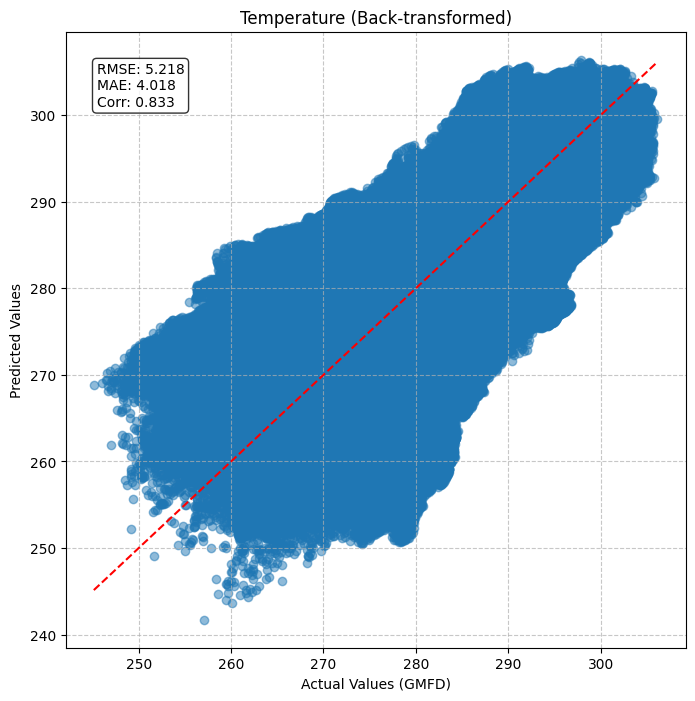

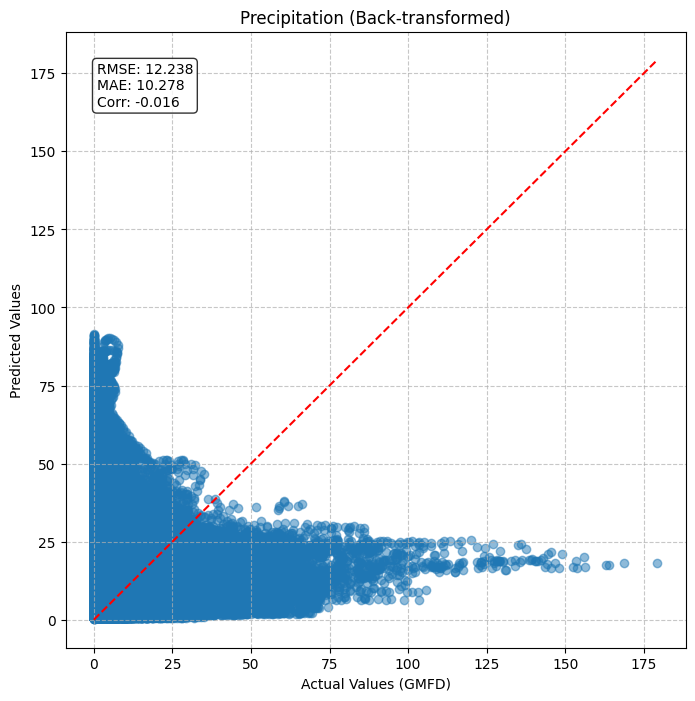

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_and_plot(y_test_denorm, y_pred_denorm, title="Predicted vs Actual"):
    """
    Calculates RMSE, MAE, and correlation, and generates a scatter plot
    of predicted vs. actual values.

    Args:
        y_test_denorm (np.ndarray): The actual/observed (denormalized) values.
        y_pred_denorm (np.ndarray): The predicted (denormalized) values.
        title (str, optional): The title of the plot. Defaults to "Predicted vs Actual".
    """

    # Calculate RMSE, MAE, and correlation
    rmse = np.sqrt(mean_squared_error(y_test_denorm.flatten(), y_pred_denorm.flatten()))
    mae = mean_absolute_error(y_test_denorm.flatten(), y_pred_denorm.flatten())
    correlation = np.corrcoef(y_test_denorm.flatten(), y_pred_denorm.flatten())[0,1]

    # Create the plot
    plt.figure(figsize=(8, 8))
    plt.grid(True, linestyle='--', alpha=0.7)  # Add grid
    plt.scatter(y_test_denorm.flatten(), y_pred_denorm.flatten(), alpha=0.5)
    plt.xlabel('Actual Values (GMFD)')
    plt.ylabel('Predicted Values')
    plt.title(f'{title} (Back-transformed)')
    plt.plot([y_test_denorm.min(), y_test_denorm.max()],
            [y_test_denorm.min(), y_test_denorm.max()], 'r--')

    # Add RMSE, MAE, and correlation text to the upper left
    plt.text(0.05, 0.95, f'RMSE: {rmse:.3f}\nMAE: {mae:.3f}\nCorr: {correlation:.3f}',
            transform=plt.gca().transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.show()

evaluate_and_plot(y_test_denorm_tas, y_pred_denorm_tas, title="Temperature")
evaluate_and_plot(y_test_denorm_pr_back, y_pred_denorm_pr_back, title="Precipitation")




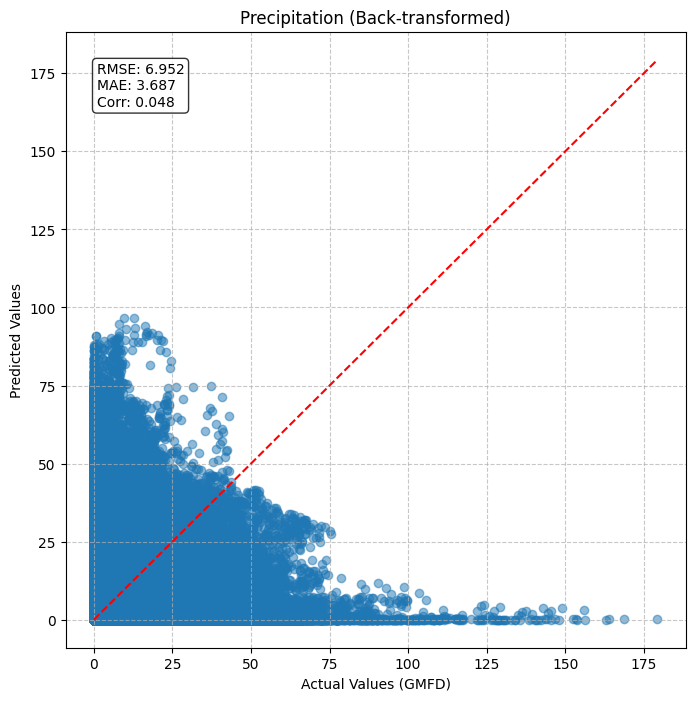

In [22]:
evaluate_and_plot( gmfd_pr['prcp'].values[index_2009:], cmip6_high_pr.values[index_2009:], title="Precipitation")

#### Train the on All Data
Train the model on all the data (no splitting)

In [18]:
X_all = np.concatenate((X_train_seq, X_val_seq, X_test_seq), axis=0)
y_all = np.concatenate((y_train_seq, y_val_seq, y_test_seq), axis=0)
res_all = np.concatenate((res_train_seq, res_val_seq, res_test_seq), axis=0)

In [19]:
import tensorflow as tf
from keras.optimizers import AdamW
from keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN


# Model setup
input_shape = (7, 42, 97, 4)
patch_size = (7, 7, 7)

model = vit_transformer(
    input_shape=input_shape,
    patch_size=patch_size,
    embed_dim=300,
    num_heads=10,
    transformer_layers=8,
    mlp_dim=512,
    dropout=0.2,
    weight_decay=0.01
)


climate_loss = ClimateDownscalingLoss(
    spatial_weight_temp=0.1,
    gradient_weight_temp=0.5,
    temporal_weight_temp=0.5,
    spatial_weight_precip=0.5,
    gradient_weight_precip=0.5,
    temporal_weight_precip=0.05,
    mse_weight_temp=1.0,
    mse_weight_precip=1.0,
    observation_weight=0.3

)


# Training parameters
epochs = 500
batch_size = 100

# Learning rate schedule using CosineDecayRestarts
initial_learning_rate = 1e-4
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=initial_learning_rate,
    first_decay_steps=50,  # Number of steps in the first cycle
    t_mul=2.0,             # Cycle length multiplier
    m_mul=0.8,             # Multiplier for the max learning rate
    alpha=1e-6             # Minimum learning rate
)

# Optimizer with learning rate schedule
optimizer = AdamW(learning_rate=lr_schedule, weight_decay=1e-5)


# Compile the model
model.compile(
    optimizer=optimizer,
    loss=climate_loss,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError()
    ]
)

# Custom callback to log learning rate
class LRLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if hasattr(lr, 'numpy'):
            lr = lr.numpy()
        print(f'\nLearning rate for epoch {epoch+1} is {lr}')

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        min_delta=1e-4
    ),
    ModelCheckpoint(
        filepath='models/vit_transformer_final_model.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    TerminateOnNaN(),
    LRLogger()  # Add the learning rate logger
]


# Perform training
history = model.fit(
    X_all, res_all,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1,
    shuffle=False  # Sequential data training
)

# Summarize results
print("\nTraining completed.")
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
print(f"Best validation loss: {best_val_loss:.6f} at epoch {best_epoch}")


Epoch 1/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 62.7196 - mean_absolute_error: 0.1180 - root_mean_squared_error: 0.1809
Epoch 1: val_loss improved from inf to 47.96973, saving model to models/vit_transformer_final_model.keras

Learning rate for epoch 1 is 5.78885859314545e-05
190/190 ━━━━━━━━━━━━━━━━━━━━ 184s 455ms/step - loss: 62.6918 - mean_absolute_error: 0.1179 - root_mean_squared_error: 0.1809 - val_loss: 47.9697 - val_mean_absolute_error: 0.1052 - val_root_mean_squared_error: 0.1714
Epoch 2/500
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 44.3748 - mean_absolute_error: 0.1031 - root_mean_squared_error: 0.1681
Epoch 2: val_loss improved from 47.96973 to 38.31924, saving model to models/vit_transformer_final_model.keras

Learning rate for epoch 2 is 5.049271946951058e-05
190/190 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 44.3636 - mean_absolute_error: 0.1031 - root_mean_squared_error: 0.1681 - val_loss: 38.3192 - val_mean_absolute_error: 0.1032 - val_root_mean_s

## Make prediction

In [25]:
from keras.models import load_model
model_saved = load_model('models/vit_transformer_final_model.keras')

### Historical

In [26]:
# Load the CMIP6 raw data (predictor variables)
cmip6_historical = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical = xr.open_zarr(cmip6_historical)
cmip6_historical_high_res = cmip6_historical.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_historical_tas_min = cmip6_historical_high_res['tas'].min().values
cmip6_historical_tas_max = cmip6_historical_high_res['tas'].max().values
cmip6_historical_norm = normalize(cmip6_historical_high_res['tas'])
cmip6_historical_norm = cmip6_historical_norm.values
cmip6_historical_norm_reshaped = cmip6_historical_norm[..., np.newaxis]


cmip6_historical_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_pr = xr.open_zarr(cmip6_historical_pr)
cmip6_historical_pr = cmip6_historical_pr * 86400
cmip6_historical_pr_high_res = cmip6_historical_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_pr_high_res['pr'] = xr.where(cmip6_historical_pr_high_res['pr'] < 0, 0, cmip6_historical_pr_high_res['pr'])

cmip6_historical_pr_high_res_log1p = cmip6_historical_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_historical_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_historical_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_historical_pr_min = cmip6_historical_pr_high_res_log1p['pr'].min().values
cmip6_historical_pr_max = cmip6_historical_pr_high_res_log1p['pr'].max().values

cmip6_historical_pr_norm_log1p = normalize(cmip6_historical_pr_high_res_log1p ['pr'])
cmip6_historical_pr_norm_log1p = cmip6_historical_pr_norm_log1p.values
cmip6_historical_pr_norm_log1p_reshaped = cmip6_historical_pr_norm_log1p[..., np.newaxis]

cmip6_historical_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/historical/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cmip6_historical_psl = xr.open_zarr(cmip6_historical_psl)
cmip6_historical_psl_high_res = cmip6_historical_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_historical_psl_norm = normalize(cmip6_historical_psl_high_res['psl'])
cmip6_historical_psl_norm = cmip6_historical_psl_norm.values
cmip6_historical_psl_norm_reshaped = cmip6_historical_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_historical_norm_reshaped), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]

# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_historical_norm_reshaped, cmip6_historical_pr_norm_log1p_reshaped, cmip6_historical_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)

# temperature
predicted_high_res_tas = cmip6_historical_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_historical_tas_max- cmip6_historical_tas_min) + cmip6_historical_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_historical_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_historical_pr_max - cmip6_historical_pr_min) + cmip6_historical_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_historical_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_historical_high_res['tas'].dims, coords=cmip6_historical_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_pr_vit.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


742/742 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step
Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


### Scenario data

#### SSP 126

In [27]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp126 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp126 = xr.open_zarr(cmip6_ssp126)
cmip6_sp126_high_res = cmip6_ssp126.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp126_tas_min = cmip6_sp126_high_res['tas'].min().values
cmip6_sp126_tas_max = cmip6_sp126_high_res['tas'].max().values
cmip6_sp126_norm = normalize(cmip6_sp126_high_res['tas'])
cmip6_sp126_norm = cmip6_sp126_norm.values
cmip6_sp126_norm_reshaped = cmip6_sp126_norm[..., np.newaxis]


cmip6_sp126_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_pr = xr.open_zarr(cmip6_sp126_pr)
cmip6_sp126_pr = cmip6_sp126_pr * 86400
cmip6_sp126_pr_high_res = cmip6_sp126_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_pr_high_res['pr'] = xr.where(cmip6_sp126_pr_high_res['pr'] < 0, 0, cmip6_sp126_pr_high_res['pr'])

cmip6_sp126_pr_high_res_log1p = cmip6_sp126_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp126_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp126_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp126_pr_min = cmip6_sp126_pr_high_res_log1p['pr'].min().values
cmip6_sp126_pr_max = cmip6_sp126_pr_high_res_log1p['pr'].max().values

cmip6_sp126_pr_norm_log1p = normalize(cmip6_sp126_pr_high_res_log1p ['pr'])
cmip6_sp126_pr_norm_log1p = cmip6_sp126_pr_norm_log1p.values
cmip6_sp126_pr_norm_log1p_reshaped = cmip6_sp126_pr_norm_log1p[..., np.newaxis]

cmip6_sp126_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp126/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp126_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp126_psl = xr.open_zarr(cmip6_sp126_psl)
cmip6_sp126_psl_high_res = cmip6_sp126_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp126_psl_norm = normalize(cmip6_sp126_psl_high_res['psl'])
cmip6_sp126_psl_norm = cmip6_sp126_psl_norm.values
cmip6_sp126_psl_norm_reshaped = cmip6_sp126_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp126_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp126_norm_reshaped, cmip6_sp126_pr_norm_log1p_reshaped, cmip6_sp126_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)

# temperature
predicted_high_res_tas = cmip6_sp126_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp126_tas_max- cmip6_sp126_tas_min) + cmip6_sp126_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp126_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp126_pr_max - cmip6_sp126_pr_min) + cmip6_sp126_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp126_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp126_high_res['tas'].dims, coords=cmip6_sp126_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_pr_vit_ssp126.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


982/982 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step
Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


In [28]:
predicted_high_res_denorm[predicted_high_res_denorm < 0] = 0
predicted_high_res_denorm.min()

0.0

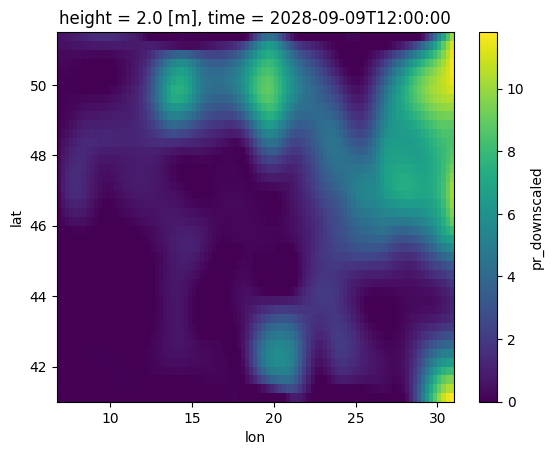

In [29]:
predicted_pr.isel(time=5000).plot() 

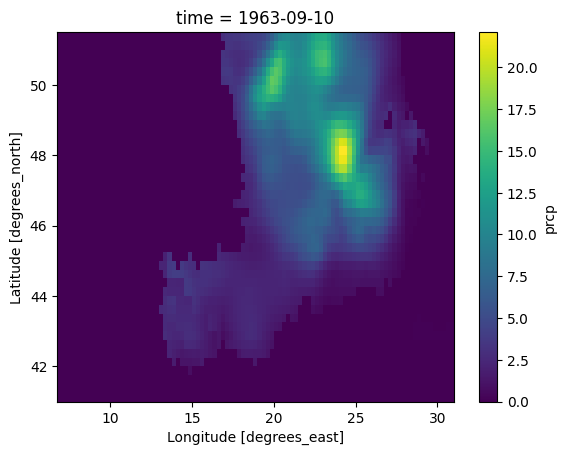

In [30]:
gmfd_pr['prcp'].isel(time=5000).plot() # Use .compute() if using Dask

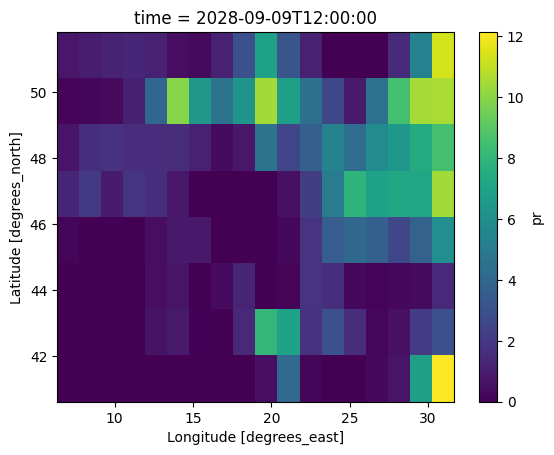

In [31]:
cmip6_sp126_pr['pr'].isel(time=5000).plot()  # Use .compute() if using Dask

#### SSP 245

In [32]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp245 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp245 = xr.open_zarr(cmip6_ssp245)
cmip6_sp245_high_res = cmip6_ssp245.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp245_tas_min = cmip6_sp245_high_res['tas'].min().values
cmip6_sp245_tas_max = cmip6_sp245_high_res['tas'].max().values
cmip6_sp245_norm = normalize(cmip6_sp245_high_res['tas'])
cmip6_sp245_norm = cmip6_sp245_norm.values
cmip6_sp245_norm_reshaped = cmip6_sp245_norm[..., np.newaxis]


cmip6_sp245_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_pr = xr.open_zarr(cmip6_sp245_pr)
cmip6_sp245_pr = cmip6_sp245_pr * 86400
cmip6_sp245_pr_high_res = cmip6_sp245_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_pr_high_res['pr'] = xr.where(cmip6_sp245_pr_high_res['pr'] < 0, 0, cmip6_sp245_pr_high_res['pr'])

cmip6_sp245_pr_high_res_log1p = cmip6_sp245_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp245_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp245_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp245_pr_min = cmip6_sp245_pr_high_res_log1p['pr'].min().values
cmip6_sp245_pr_max = cmip6_sp245_pr_high_res_log1p['pr'].max().values

cmip6_sp245_pr_norm_log1p = normalize(cmip6_sp245_pr_high_res_log1p ['pr'])
cmip6_sp245_pr_norm_log1p = cmip6_sp245_pr_norm_log1p.values
cmip6_sp245_pr_norm_log1p_reshaped = cmip6_sp245_pr_norm_log1p[..., np.newaxis]

cmip6_sp245_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp245/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp245_psl = xr.open_zarr(cmip6_sp245_psl)
cmip6_sp245_psl_high_res = cmip6_sp245_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp245_psl_norm = normalize(cmip6_sp245_psl_high_res['psl'])
cmip6_sp245_psl_norm = cmip6_sp245_psl_norm.values
cmip6_sp245_psl_norm_reshaped = cmip6_sp245_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp245_psl_norm_reshaped ), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp245_norm_reshaped, cmip6_sp245_pr_norm_log1p_reshaped, cmip6_sp245_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)

# temperature
predicted_high_res_tas = cmip6_sp245_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp245_tas_max- cmip6_sp245_tas_min) + cmip6_sp245_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp245_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp245_pr_max - cmip6_sp245_pr_min) + cmip6_sp245_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp245_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp245_high_res['tas'].dims, coords=cmip6_sp245_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_pr_vit_ssp245.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


982/982 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step
Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


#### SSP 585

In [33]:
# Load the CMIP6 raw data (predictor variables)
cmip6_ssp585 = '/data/cristi/a/cristi/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_ssp585 = xr.open_zarr(cmip6_ssp585)
cmip6_sp585_high_res = cmip6_ssp585.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
# Get the mean and std from the training set for denormalization
cmip6_sp585_tas_min = cmip6_sp585_high_res['tas'].min().values
cmip6_sp585_tas_max = cmip6_sp585_high_res['tas'].max().values
cmip6_sp585_norm = normalize(cmip6_sp585_high_res['tas'])
cmip6_sp585_norm = cmip6_sp585_norm.values
cmip6_sp585_norm_reshaped = cmip6_sp585_norm[..., np.newaxis]


cmip6_sp585_pr = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/pr/pr_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_pr = xr.open_zarr(cmip6_sp585_pr)
cmip6_sp585_pr = cmip6_sp585_pr * 86400
cmip6_sp585_pr_high_res = cmip6_sp585_pr.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_pr_high_res['pr'] = xr.where(cmip6_sp585_pr_high_res['pr'] < 0, 0, cmip6_sp585_pr_high_res['pr'])

cmip6_sp585_pr_high_res_log1p = cmip6_sp585_pr_high_res.copy()  # Make a copy to avoid modifying the original dataset
cmip6_sp585_pr_high_res_log1p = xr.apply_ufunc(np.log1p, cmip6_sp585_pr_high_res_log1p  ,dask="parallelized", output_dtypes=[float])
cmip6_sp585_pr_min = cmip6_sp585_pr_high_res_log1p['pr'].min().values
cmip6_sp585_pr_max = cmip6_sp585_pr_high_res_log1p['pr'].max().values

cmip6_sp585_pr_norm_log1p = normalize(cmip6_sp585_pr_high_res_log1p ['pr'])
cmip6_sp585_pr_norm_log1p = cmip6_sp585_pr_norm_log1p.values
cmip6_sp585_pr_norm_log1p_reshaped = cmip6_sp585_pr_norm_log1p[..., np.newaxis]

cmip6_sp585_psl = '/data/keeling/a/ad87/cmip6/zarr/RO_CMIP6_raw/CNRM-ESM2-1/ssp585/r1i1p1f2/psl/psl_day_CNRM-ESM2-1_ssp585_r1i1p1f2_gr_2015_2100_rou.zarr'
cmip6_sp585_psl = xr.open_zarr(cmip6_sp585_psl)
cmip6_sp585_psl_high_res = cmip6_sp585_psl.interp(lat=target_lat, lon=target_lon, method='cubic', kwargs={"fill_value": "extrapolate"})
cmip6_sp585_psl_norm = normalize(cmip6_sp585_psl_high_res['psl'])
cmip6_sp585_psl_norm = cmip6_sp585_psl_norm.values
cmip6_sp585_psl_norm_reshaped = cmip6_sp585_psl_norm[..., np.newaxis]

elev_dif_norm_final = np.repeat(elev_dif_norm[np.newaxis :, :], len(cmip6_sp585_psl_norm), axis=0)
elev_dif_norm_final = elev_dif_norm_final[..., np.newaxis]


# Concatenate the reshaped arrays along the last axis
cmip6_scen_combined = np.concatenate((cmip6_sp585_norm_reshaped, cmip6_sp585_pr_norm_log1p_reshaped, cmip6_sp585_psl_norm_reshaped, elev_dif_norm_final), axis=-1)
# Predict downscaled high-resolution data
X_scen = create_temporal_sequences_centered(cmip6_scen_combined, window_size) 
predicted_high_res = model_saved.predict(X_scen)

# temperature
predicted_high_res_tas = cmip6_sp585_norm_reshaped +  predicted_high_res[:,window_size,:,:,:1]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_tas * (cmip6_sp585_tas_max- cmip6_sp585_tas_min) + cmip6_sp585_tas_min
# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_tas = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='tas_downscaled')
predicted_tas.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_tas_vit_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")

# precipitation
predicted_high_res_pr = cmip6_sp585_pr_norm_log1p_reshaped  +  predicted_high_res[:,window_size,:,:,1:2]
# Back-transform the predictions and actual values
predicted_high_res_denorm = predicted_high_res_pr * (cmip6_sp585_pr_max - cmip6_sp585_pr_min) + cmip6_sp585_pr_min
predicted_high_res_denorm_back = np.expm1(predicted_high_res_denorm)
predicted_high_res_denorm_back[predicted_high_res_denorm_back < 0] = 0 # Replace negative values with 0

# Reshape the predictions to match the original GMFD resolution
predicted_high_res_final = predicted_high_res_denorm_back.reshape(cmip6_sp585_high_res['tas'].shape)
# Save the predictions to a NetCDF file
predicted_pr = xr.DataArray(predicted_high_res_final, dims=cmip6_sp585_high_res['tas'].dims, coords=cmip6_sp585_high_res['tas'].coords, name='pr_downscaled')
predicted_pr.to_netcdf('/data/keeling/a/ad87/downscale/ncs/vit/predicted_high_res_pr_vit_ssp585.nc')
# #### Results saved to NetCDF format
print("Downscaled high-resolution predictions saved to NetCDF format.")


982/982 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step
Downscaled high-resolution predictions saved to NetCDF format.
Downscaled high-resolution predictions saved to NetCDF format.


In [34]:
import graphviz

dot = graphviz.Digraph(format='png')
dot.attr(rankdir='TB', size="8,10")

dot.attr('node', shape='box', style='filled', fillcolor="#E0E5E8", fontname="Helvetica")

dot.node('Input', 'Input\n(7, 42, 97, 4)')

dot.node('Embedding', '''Residual Multi-Scale Patch Embedding
- 3D Conv (3x3x3, 4x4x4, 5x5x5)
- Fusion Conv3D (1x1x1)
- Residual Projection (1x1x1)
- Reshape to Sequence (patches, 320)''')

dot.node('PosEnc', 'Fourier Positional Encoding\n(sin/cos encoding)')

dot.node('Transformer', '''Spatial-Temporal Transformer Blocks
(6 layers)
- Multi-Head Attention (8 heads, key dim=40)
- Residual + Layer Norm
- MLP (Dense 512, GELU, Dropout)''')

dot.node('Reshape', 'Reshape to Temporal Sequence\n(7, Spatial_Patches x 320)')

dot.node('TDense', '''TimeDistributed Dense Layers
- Dense (256, GELU) + Dropout
- Dense (42×97×2, Linear)
- Reshape to (42, 97, 2)''')

dot.node('Output', 'Output\n(7, 42, 97, 2)')

dot.edges([
    ('Input', 'Embedding'),
    ('Embedding', 'PosEnc'),
    ('PosEnc', 'Transformer'),
    ('Transformer', 'Reshape'),
    ('Reshape', 'TDense'),
    ('TDense', 'Output')
])

# Save and display the diagram
dot.render('vit_model_diagram', view=False)


'vit_model_diagram.png'